# Mass Shootings in the United States: 


This notebook performs an exploratory data analysis (EDA) and some other models like clusterning .. etc on a dataset of mass shootings in the United States. 
The dataset includes details on incidents, locations, shooter demographics, weapon types, and mental health indicators. 
The goal of this EDA is to uncover trends and patterns in the data to support further research and policy recommendations.

### Dataset Loading
Load the dataset and examine the structure.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import folium
from folium.plugins import HeatMap

# Load the dataset
file_path = 'US_Mass_Shootings.csv'
mass_shootings_data = pd.read_csv(file_path)

# Display the first few rows and basic info
mass_shootings_data.head(), mass_shootings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   case                              151 non-null    object
 1   location                          151 non-null    object
 2   date                              151 non-null    object
 3   summary                           151 non-null    object
 4   fatalities                        151 non-null    int64 
 5   injured                           151 non-null    int64 
 6   total_victims                     151 non-null    int64 
 7   location.1                        151 non-null    object
 8   age_of_shooter                    151 non-null    object
 9   prior_signs_mental_health_issues  151 non-null    object
 10  mental_health_details             151 non-null    object
 11  weapons_obtained_legally          151 non-null    object
 12  where_obtained        

(                                         case               location  \
 0              Apalachee High School shooting        Winder, Georgia   
 1             Arkansas grocery store shooting      Fordyce, Arkansas   
 2                               UNLV shooting      Las Vegas, Nevada   
 3       Maine bowling alley and bar shootings        Lewiston, Maine   
 4  Jacksonville Dollar General store shooting  Jacksonville, Florida   
 
        date                                            summary  fatalities  \
 0    9/4/24  Colt Gray, 14, was apprehended by responding p...           4   
 1   6/21/24  Travis Posey, 44, opened fire in the parking l...           4   
 2   12/6/23  Anthony Polito, 67, a former university profes...           3   
 3  10/25/23  Robert Card, 40, an Army reservist and firearm...          18   
 4   8/26/23  Ryan Palmeter, 21, outfitted in body armor, fa...           3   
 
    injured  total_victims location.1 age_of_shooter  \
 0        9             13  

### Data Cleaning and Preparation

In [3]:

# Convert age_of_shooter to numeric, replacing non-numeric values with NaN
mass_shootings_data['age_of_shooter'] = pd.to_numeric(mass_shootings_data['age_of_shooter'], errors='coerce')

# Standardize 'prior_signs_mental_health_issues' column by converting to lowercase for consistency
mass_shootings_data['prior_signs_mental_health_issues'] = mass_shootings_data['prior_signs_mental_health_issues'].str.lower()

# Replace '-' and empty strings in mental health and weapon columns with NaN
mass_shootings_data.replace(['-', ''], pd.NA, inplace=True)

# Check cleaned data summary
mass_shootings_data.describe(include='all')


,case,location,date,summary,fatalities,injured,total_victims,location.1,age_of_shooter,prior_signs_mental_health_issues,...,weapon_details,race,gender,sources,mental_health_sources,sources_additional_age,latitude,longitude,type,year
count,151,151,151,151,151.000000,151.000000,151.000000,151,149.000000,120,...,123,139,151,151,91,100,126,126,151,151.000000
unique,151,136,151,151,NaN,NaN,NaN,10,NaN,6,...,115,10,6,151,91,100,126,126,3,NaN
top,Apalachee High School shooting,"Colorado Springs, Colorado",9/4/24,"Colt Gray, 14, was apprehended by responding p...",NaN,NaN,NaN,Other,NaN,yes,...,AR-15,white,M,https://www.nbcnews.com/news/us-news/suspect-c...,https://www.washingtonpost.com/nation/2024/09/...,https://www.chron.com/news/houston-texas/artic...,38.60111019,-121.4189659,Mass,NaN
freq,1,3,1,1,NaN,NaN,NaN,55,NaN,74,...,3,41,75,1,1,1,1,1,122,NaN
mean,NaN,NaN,NaN,NaN,7.675497,10.907285,18.582781,NaN,34.154362,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.231788
std,NaN,NaN,NaN,NaN,7.412197,45.023453,50.211069,NaN,13.478574,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.910205
min,NaN,NaN,NaN,NaN,3.000000,0.000000,3.000000,NaN,11.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1982.000000
25%,NaN,NaN,NaN,NaN,4.000000,1.000000,6.000000,NaN,22.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006.000000
50%,NaN,NaN,NaN,NaN,6.000000,3.000000,10.000000,NaN,33.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015.000000
75%,NaN,NaN,NaN,NaN,8.000000,10.000000,16.500000,NaN,43.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019.000000


### Feedback improved things 

In [4]:
# Convert age_of_shooter to numeric, replacing non-numeric values with NaN
mass_shootings_data['age_of_shooter'] = pd.to_numeric(mass_shootings_data['age_of_shooter'], errors='coerce')

# Clean 'prior_signs_mental_health_issues' column
mass_shootings_data['prior_signs_mental_health_issues'] = mass_shootings_data['prior_signs_mental_health_issues'].str.lower()

# Replace '-' and empty strings with NaN
mass_shootings_data.replace(['-', ''], np.nan, inplace=True)

# Convert race and gender categories to consistent labels
mass_shootings_data['race'] = mass_shootings_data['race'].str.lower().str.strip()
mass_shootings_data['gender'] = mass_shootings_data['gender'].str.lower().str.strip()

# Collapse location types into fewer categories
location_mapping = {
    'workplace': 'workplace',
    'school': 'educational',
    'other': 'other',
    'residence': 'residential',
    'outdoor': 'public',
    'commercial': 'commercial'
}
mass_shootings_data['location.1'] = mass_shootings_data['location.1'].map(location_mapping)

# Convert date column to datetime
mass_shootings_data['date'] = pd.to_datetime(mass_shootings_data['date'], errors='coerce')

# Extract year and month
mass_shootings_data['year'] = mass_shootings_data['date'].dt.year
mass_shootings_data['month'] = mass_shootings_data['date'].dt.month

/var/folders/bj/cvddf8ks4xj31dqcgqwf2zz40000gn/T/ipykernel_5757/1871620703.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mass_shootings_data['date'] = pd.to_datetime(mass_shootings_data['date'], errors='coerce')


# Plot race distribution

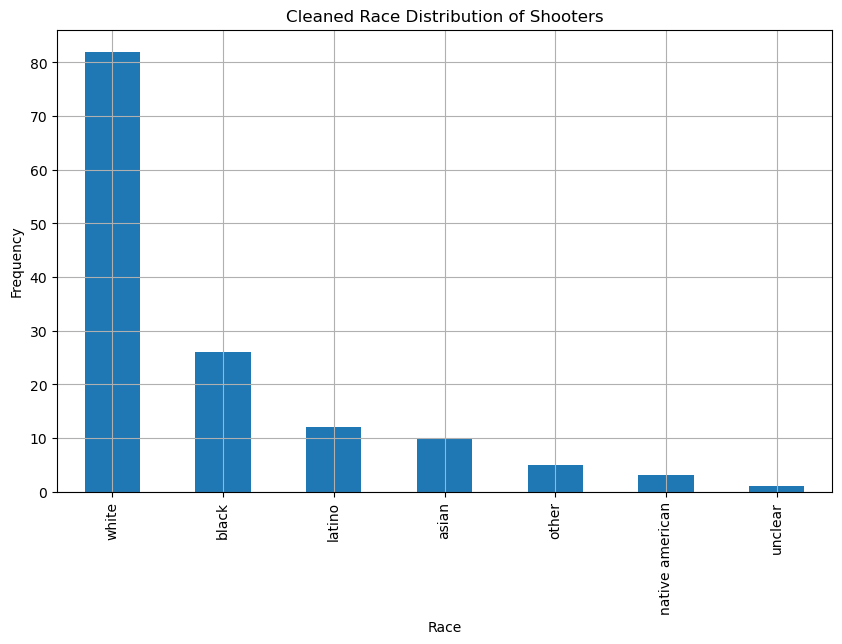

In [9]:
# Plot race distribution
plt.figure(figsize=(10, 6))
mass_shootings_data['race'].value_counts().plot(kind='bar')
plt.title("Cleaned Race Distribution of Shooters")
plt.xlabel("Race")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Temporal Analysis

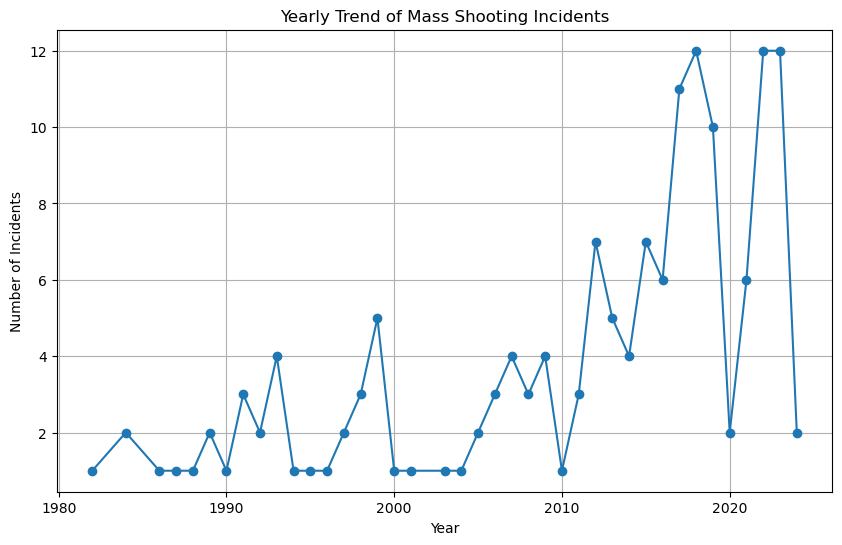

In [5]:

import matplotlib.pyplot as plt

# Convert date column to datetime format for temporal analysis
mass_shootings_data['date'] = pd.to_datetime(mass_shootings_data['date'], errors='coerce')

# Extract year and month for temporal analysis
mass_shootings_data['year'] = mass_shootings_data['date'].dt.year
mass_shootings_data['month'] = mass_shootings_data['date'].dt.month

# Plot yearly trend of mass shooting incidents
yearly_trend = mass_shootings_data.groupby('year').size()

plt.figure(figsize=(10, 6))
plt.plot(yearly_trend.index, yearly_trend.values, marker='o', linestyle='-')
plt.title("Yearly Trend of Mass Shooting Incidents")
plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.grid(True)
plt.show()


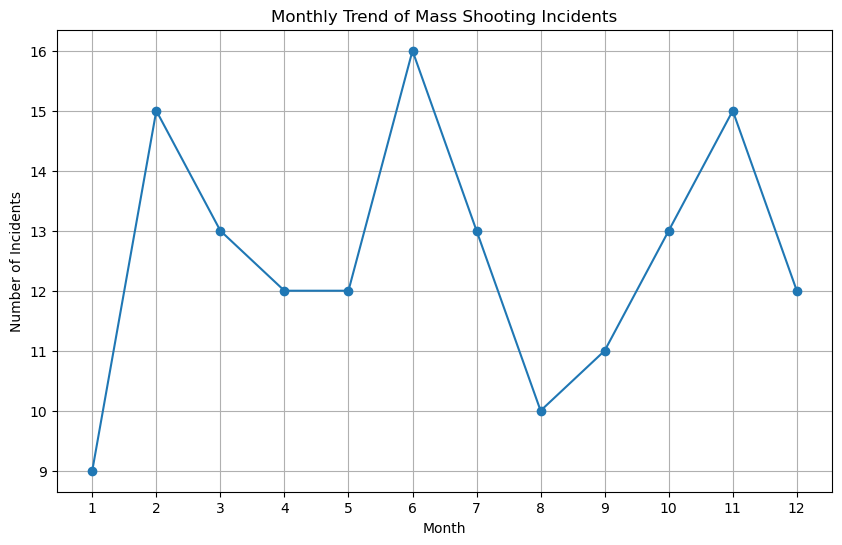

In [6]:

# Plot monthly trend of mass shooting incidents
monthly_trend = mass_shootings_data.groupby('month').size()

plt.figure(figsize=(10, 6))
plt.plot(monthly_trend.index, monthly_trend.values, marker='o', linestyle='-')
plt.title("Monthly Trend of Mass Shooting Incidents")
plt.xlabel("Month")
plt.ylabel("Number of Incidents")
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()


### Demographic Analysis

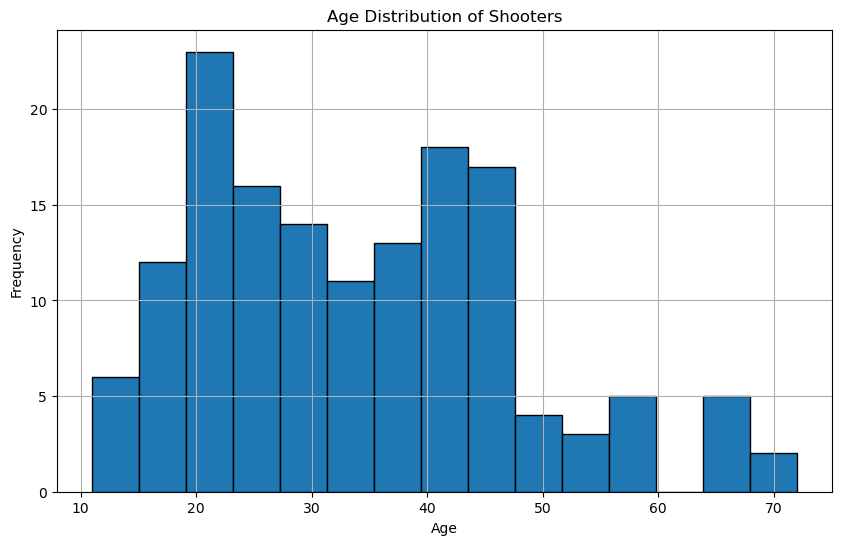

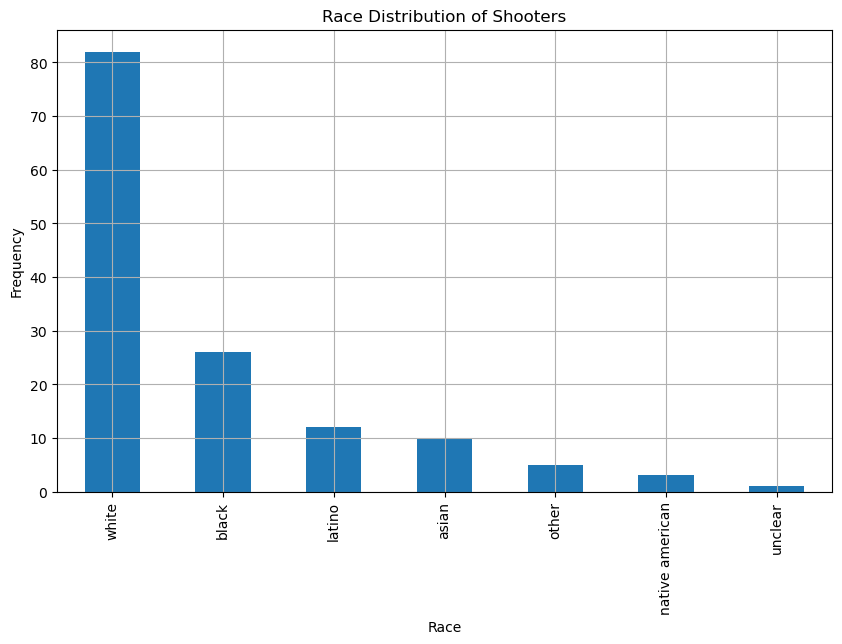

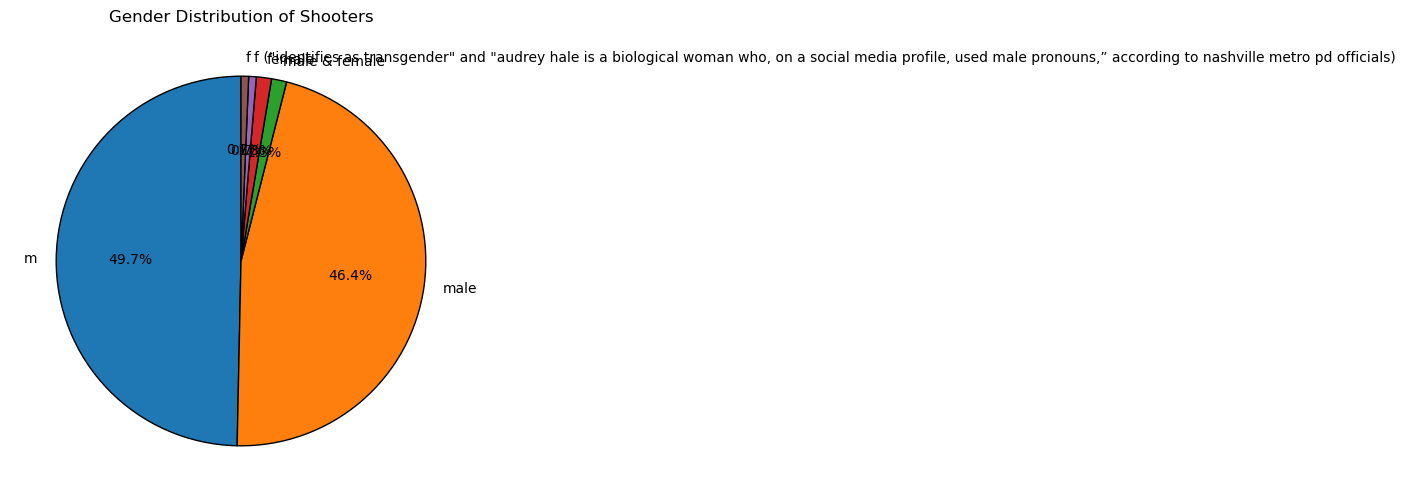

In [7]:

# Age Distribution
plt.figure(figsize=(10, 6))
plt.hist(mass_shootings_data['age_of_shooter'].dropna(), bins=15, edgecolor='black')
plt.title("Age Distribution of Shooters")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Race and Gender Distribution
race_counts = mass_shootings_data['race'].value_counts(dropna=True)
gender_counts = mass_shootings_data['gender'].value_counts(dropna=True)

# Plot race distribution
plt.figure(figsize=(10, 6))
race_counts.plot(kind='bar')
plt.title("Race Distribution of Shooters")
plt.xlabel("Race")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot gender distribution
plt.figure(figsize=(6, 6))
gender_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title("Gender Distribution of Shooters")
plt.ylabel("")
plt.show()


### Location and Weapon Type Analysis

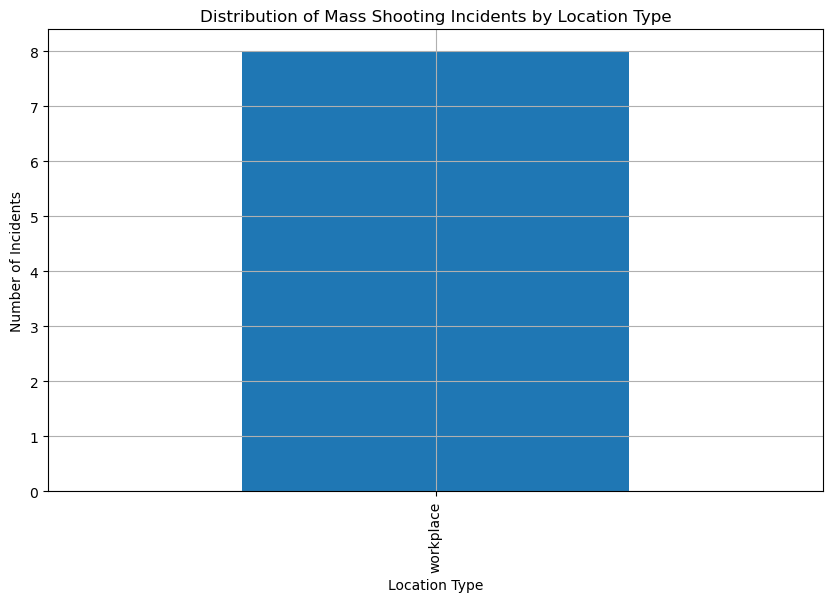

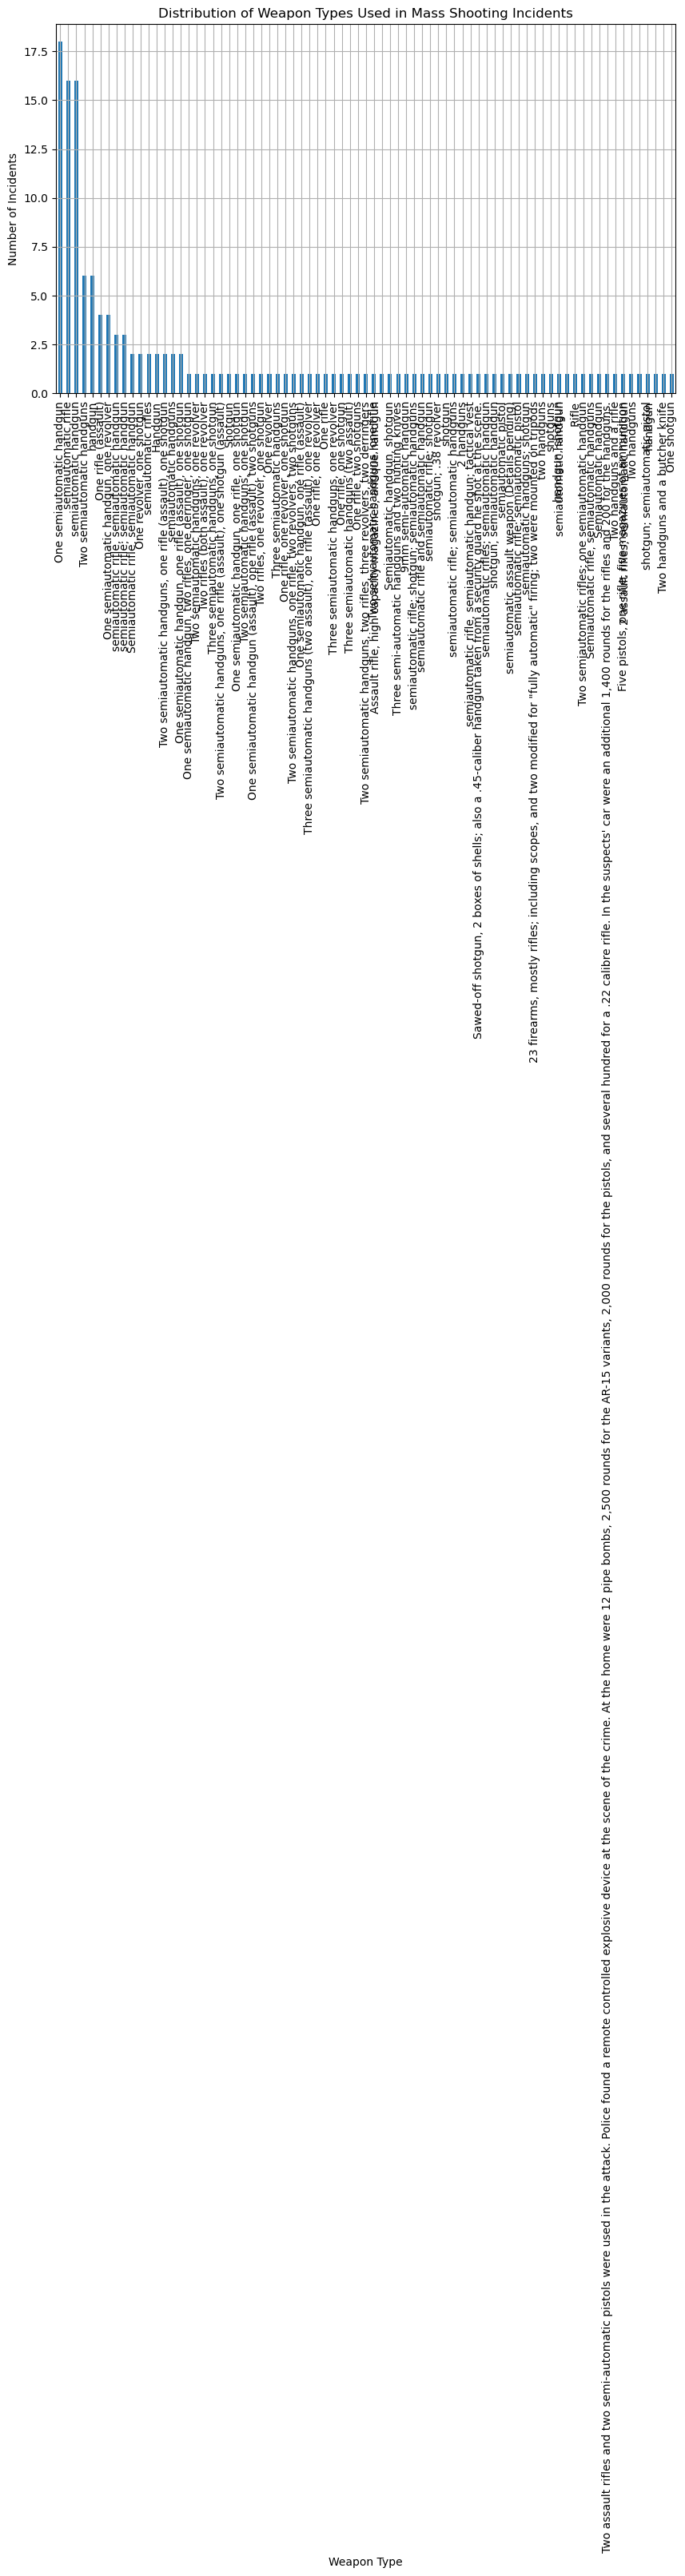

In [8]:

# Location Type Analysis
location_counts = mass_shootings_data['location.1'].value_counts()

# Plot location type distribution
plt.figure(figsize=(10, 6))
location_counts.plot(kind='bar')
plt.title("Distribution of Mass Shooting Incidents by Location Type")
plt.xlabel("Location Type")
plt.ylabel("Number of Incidents")
plt.grid(True)
plt.show()

# Weapon Type Analysis
weapon_counts = mass_shootings_data['weapon_type'].value_counts()

# Plot weapon type distribution
plt.figure(figsize=(10, 6))
weapon_counts.plot(kind='bar')
plt.title("Distribution of Weapon Types Used in Mass Shooting Incidents")
plt.xlabel("Weapon Type")
plt.ylabel("Number of Incidents")
plt.grid(True)
plt.show()


### Mental Health Indicators Analysis

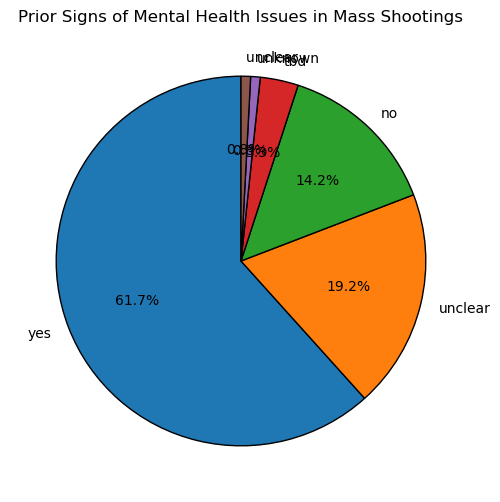

In [9]:

# Mental Health Indicators Analysis
mental_health_counts = mass_shootings_data['prior_signs_mental_health_issues'].value_counts()

# Plot mental health indicators distribution
plt.figure(figsize=(8, 6))
mental_health_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title("Prior Signs of Mental Health Issues in Mass Shootings")
plt.ylabel("")
plt.show()


C:\Users\venkateshgoud\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\venkateshgoud\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\venkateshgoud\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\venkateshgoud\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known

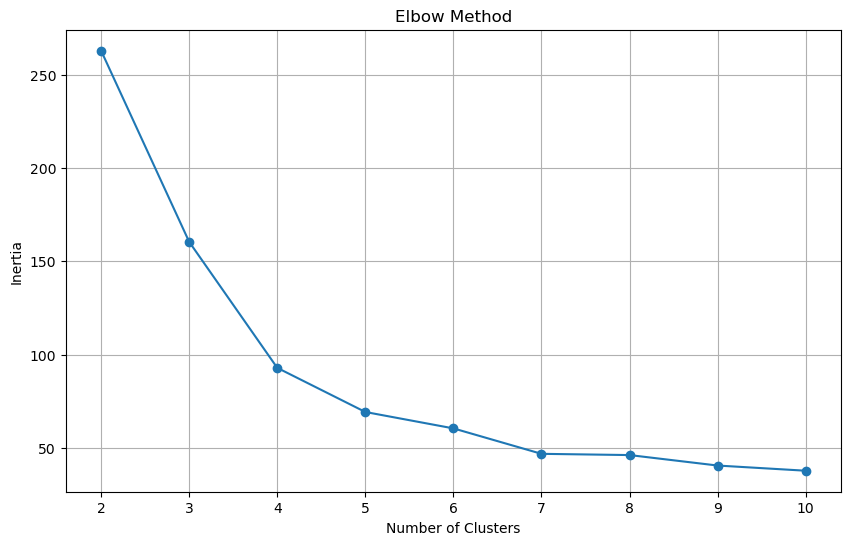

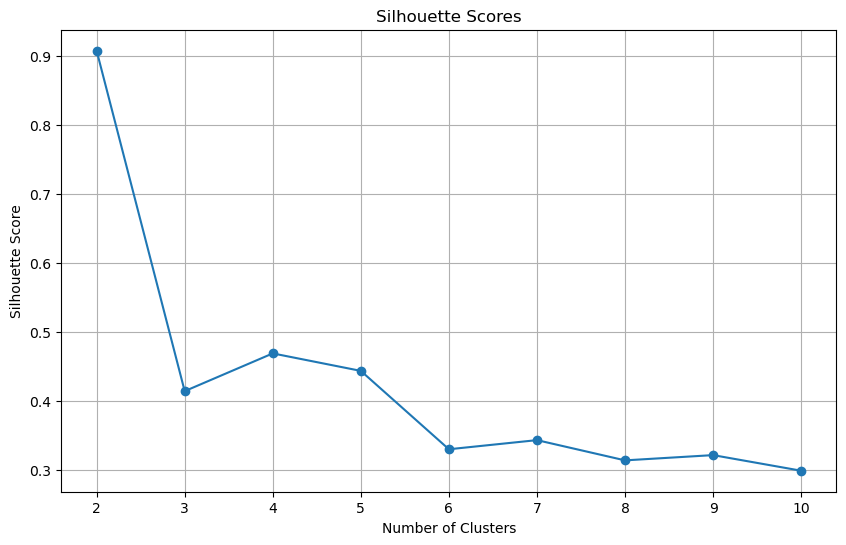

C:\Users\venkateshgoud\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\venkateshgoud\AppData\Local\Temp\ipykernel_29404\3549394016.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mass_shootings_data_cleaned['cluster'] = kmeans.fit_predict(scaled_data)


         fatalities     injured  total_victims  age_of_shooter
cluster                                                       
0         25.800000   21.000000       46.80000       27.200000
1          5.851351    8.378378       14.22973       24.054054
2          6.250000    4.187500       10.43750       46.453125
3         60.000000  546.000000      606.00000       64.000000


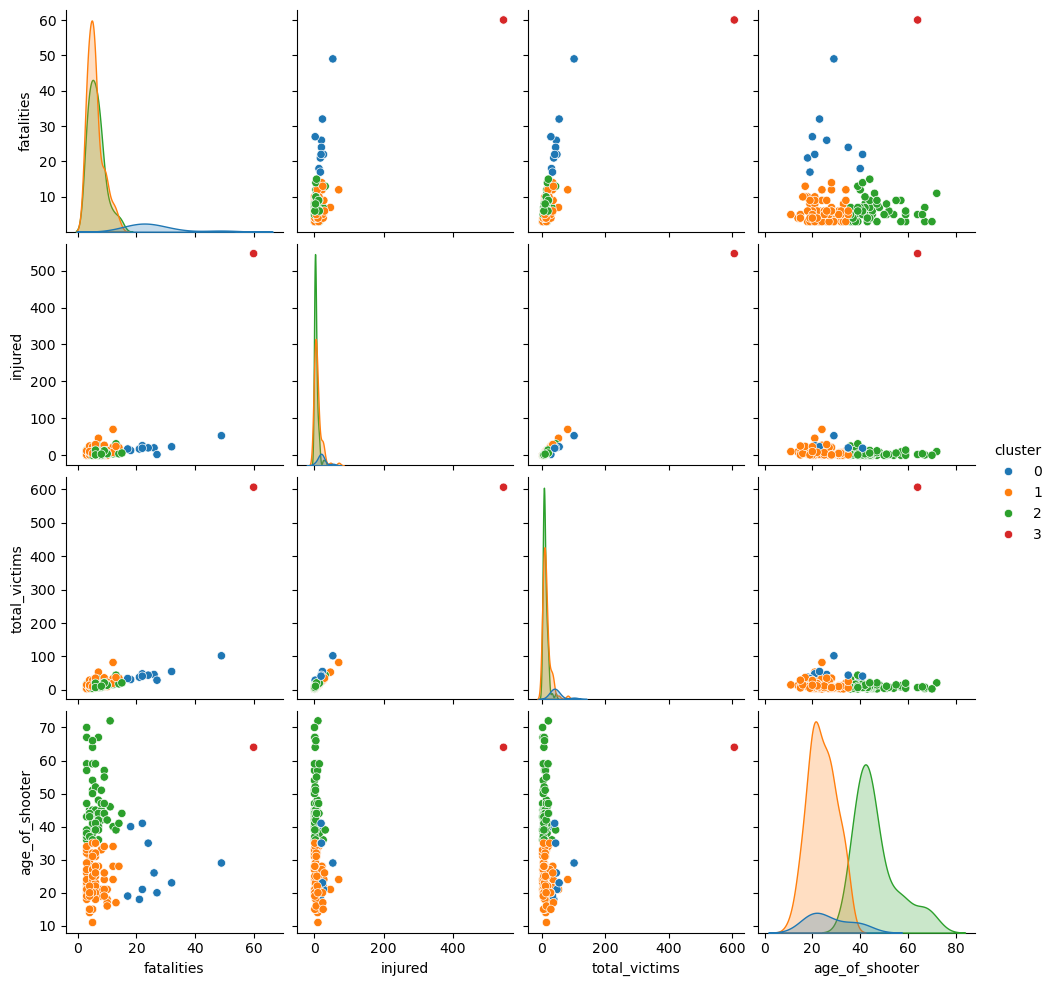

         fatalities     injured  total_victims  age_of_shooter
cluster                                                       
0         25.800000   21.000000       46.80000       27.200000
1          5.851351    8.378378       14.22973       24.054054
2          6.250000    4.187500       10.43750       46.453125
3         60.000000  546.000000      606.00000       64.000000


C:\Users\venkateshgoud\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\venkateshgoud\AppData\Local\Temp\ipykernel_29404\3549394016.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mass_shootings_data_cleaned['cluster'] = kmeans.fit_predict(scaled_data)


In [19]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns 

# Set environment variables to avoid core-related warnings
os.environ["OMP_NUM_THREADS"] = "1"

# Ensure necessary columns are numeric and clean the data
numeric_features = ['fatalities', 'injured', 'total_victims', 'age_of_shooter']
mass_shootings_data['age_of_shooter'] = pd.to_numeric(mass_shootings_data['age_of_shooter'], errors='coerce')

# Drop rows with missing or invalid data in numeric features
mass_shootings_data_cleaned = mass_shootings_data.dropna(subset=numeric_features)

# Extract clustering data and standardize
clustering_data = mass_shootings_data_cleaned[numeric_features]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

# Determine the optimal number of clusters
inertia = []
silhouette_scores = []
k_range = range(2, 11)  # Test for 2 to 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

# Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='-')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-')
plt.title("Silhouette Scores")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Perform K-Means clustering
optimal_k = 4  # Replace this with the value you determine from the Elbow Method or Silhouette Score
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
mass_shootings_data_cleaned['cluster'] = kmeans.fit_predict(scaled_data)

# Analyze cluster distribution (numeric columns only)
numeric_cols = ['fatalities', 'injured', 'total_victims', 'age_of_shooter']
cluster_summary = mass_shootings_data_cleaned.groupby('cluster')[numeric_cols].mean()

# Display the cluster summary
print(cluster_summary)

# Visualize clusters with a pairplot
sns.pairplot(mass_shootings_data_cleaned, hue='cluster', vars=numeric_features, palette='tab10')
plt.show()

# Perform clustering with the optimal number of clusters (e.g., 4)
optimal_k = 4  # Adjust based on the above results
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
mass_shootings_data_cleaned['cluster'] = kmeans.fit_predict(scaled_data)

# Analyze the clusters
cluster_summary = mass_shootings_data_cleaned.groupby('cluster')[numeric_features].mean()
print(cluster_summary)


## Step 1: Geospatial Analysis
This step involves visualizing the mass shooting incidents on a map and identifying geographic patterns using a heatmap.

In [21]:
!pip install folium


In [10]:
import folium
from folium.plugins import HeatMap

# Convert latitude and longitude to numeric, replacing errors with NaN
mass_shootings_data['latitude'] = pd.to_numeric(mass_shootings_data['latitude'], errors='coerce')
mass_shootings_data['longitude'] = pd.to_numeric(mass_shootings_data['longitude'], errors='coerce')

# Filter data with valid latitude and longitude
geo_data = mass_shootings_data.dropna(subset=['latitude', 'longitude'])

# Create a base map
map_shootings = folium.Map(location=[geo_data['latitude'].mean(), geo_data['longitude'].mean()], zoom_start=5)

# Add heatmap for shootings
heat_data = geo_data[['latitude', 'longitude']].values.tolist()
HeatMap(heat_data).add_to(map_shootings)

# Display the map
map_shootings


## Step 2: Advanced Clustering Validation
Evaluate clustering quality using the Davies-Bouldin Index.

In [11]:

from sklearn.metrics import davies_bouldin_score

# Davies-Bouldin Index for clustering quality
db_score = davies_bouldin_score(scaled_data, kmeans.labels_)
print(f"Davies-Bouldin Index for {optimal_k} clusters: {db_score}")


NameError: name 'scaled_data' is not defined

## Step 3: Predictive Modeling
Use features such as shooter demographics and geographic data to predict the number of fatalities using a Random Forest Regressor.

In [18]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prepare features and target
features = ['age_of_shooter', 'fatalities', 'latitude', 'longitude']
target = 'total_victims'

# Drop missing values for features and target
model_data = mass_shootings_data.dropna(subset=features + [target])
X = model_data[features]
y = model_data[target]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"R² Score: {r2_score(y_test, y_pred)}")


Mean Squared Error: 73.737908
R² Score: 0.5375193928750628


## Step 4: NLP Analysis
Perform topic modeling on the summaries of mass shootings to identify recurring themes.

In [15]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Extract summaries for analysis
summaries = mass_shootings_data['summary'].dropna()

# Vectorize text data
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
text_data = vectorizer.fit_transform(summaries)

# Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(text_data)

# Display topics
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx + 1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Topic 1:
['committing', 'employee', 'officer', 'responding', 'workplace', 'opened', 'suicide', 'police', 'killed', 'shot']
Topic 2:
['died', 'shootout', 'fired', 'arrested', 'killed', 'school', 'dead', 'opened', 'shot', 'police']
Topic 3:
['suicide', 'school', 'old', 'fled', 'year', 'killed', 'shot', 'later', 'police', 'opened']
Topic 4:
['fatally', 'scene', 'killed', 'inside', 'people', 'killing', 'suicide', 'shot', 'opened', 'police']
Topic 5:
['scene', 'killed', 'killing', 'later', 'fatally', 'shooting', 'shot', 'attack', 'police', 'opened']


## Step 5: Time Series Modeling
Analyze temporal trends and forecast the frequency of incidents in the coming years.

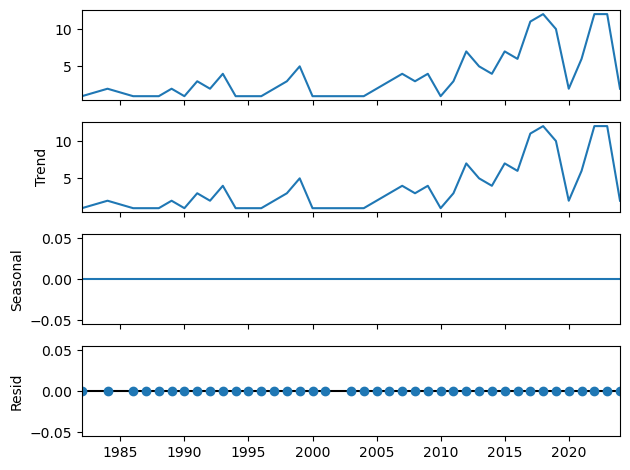

Forecasted incidents for next 5 years: 40    5.423558
41    6.349423
42    6.599814
43    6.667529
44    6.685842
Name: predicted_mean, dtype: float64


C:\Users\venkateshgoud\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\venkateshgoud\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\venkateshgoud\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\venkateshgoud\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\venkateshgoud\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported in

In [30]:

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Group data by year to count incidents
incident_trend = mass_shootings_data.groupby('year').size()

# Decompose the time series
decomposed = seasonal_decompose(incident_trend, model='additive', period=1)
decomposed.plot()
plt.show()

# Fit ARIMA model
arima_model = ARIMA(incident_trend, order=(1, 1, 1))
arima_fit = arima_model.fit()

# Forecast
forecast = arima_fit.forecast(steps=5)
print(f"Forecasted incidents for next 5 years: {forecast}")


## Step 6: Policy Impact Analysis
Examine the relationship between weapon legality and the number of fatalities using regression analysis.

In [32]:

import statsmodels.api as sm

# Encode weapon legality
mass_shootings_data['weapons_obtained_legally_encoded'] = mass_shootings_data['weapons_obtained_legally'].map({'yes': 1, 'no': 0})

# Drop missing values for the analysis
policy_data = mass_shootings_data.dropna(subset=['weapons_obtained_legally_encoded', 'fatalities'])

# Prepare variables for regression
X_policy = sm.add_constant(policy_data['weapons_obtained_legally_encoded'])  # Add constant for intercept
y_policy = policy_data['fatalities']

# Perform regression
policy_model = sm.OLS(y_policy, X_policy).fit()

# Display results
print(policy_model.summary())


                            OLS Regression Results                            
Dep. Variable:             fatalities   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                nan
Time:                        20:53:41   Log-Likelihood:                -43.992
No. Observations:                  15   AIC:                             89.98
Df Residuals:                      14   BIC:                             90.69
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
weapons_

C:\Users\venkateshgoud\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  res = hypotest_fun_out(*samples, **kwds)


# Improvements Bases on feedback 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   case                              151 non-null    object
 1   location                          151 non-null    object
 2   date                              151 non-null    object
 3   summary                           151 non-null    object
 4   fatalities                        151 non-null    int64 
 5   injured                           151 non-null    int64 
 6   total_victims                     151 non-null    int64 
 7   location.1                        151 non-null    object
 8   age_of_shooter                    151 non-null    object
 9   prior_signs_mental_health_issues  151 non-null    object
 10  mental_health_details             151 non-null    object
 11  weapons_obtained_legally          151 non-null    object
 12  where_obtained        

C:\Users\venkateshgoud\AppData\Local\Temp\ipykernel_29404\1632758563.py:52: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mass_shootings_data['date'] = pd.to_datetime(mass_shootings_data['date'], errors='coerce')


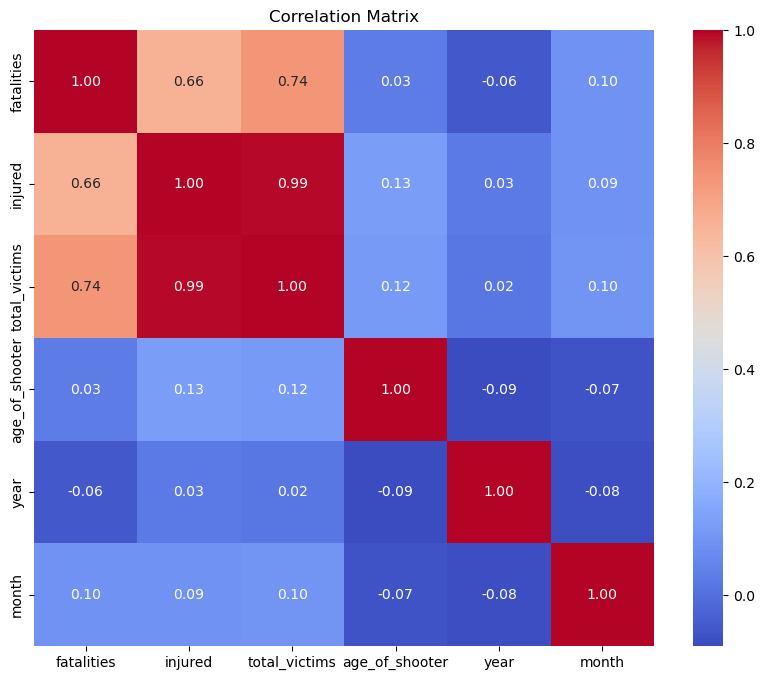

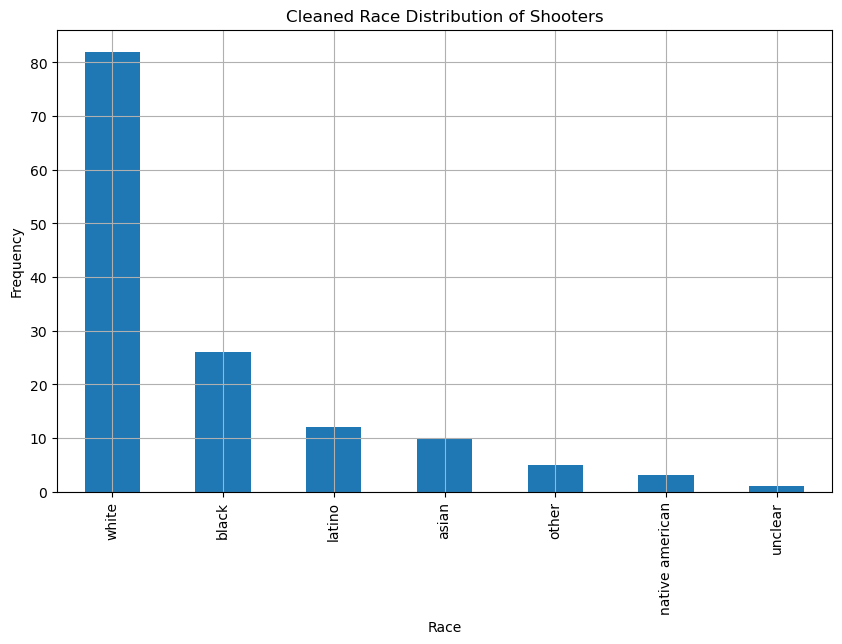

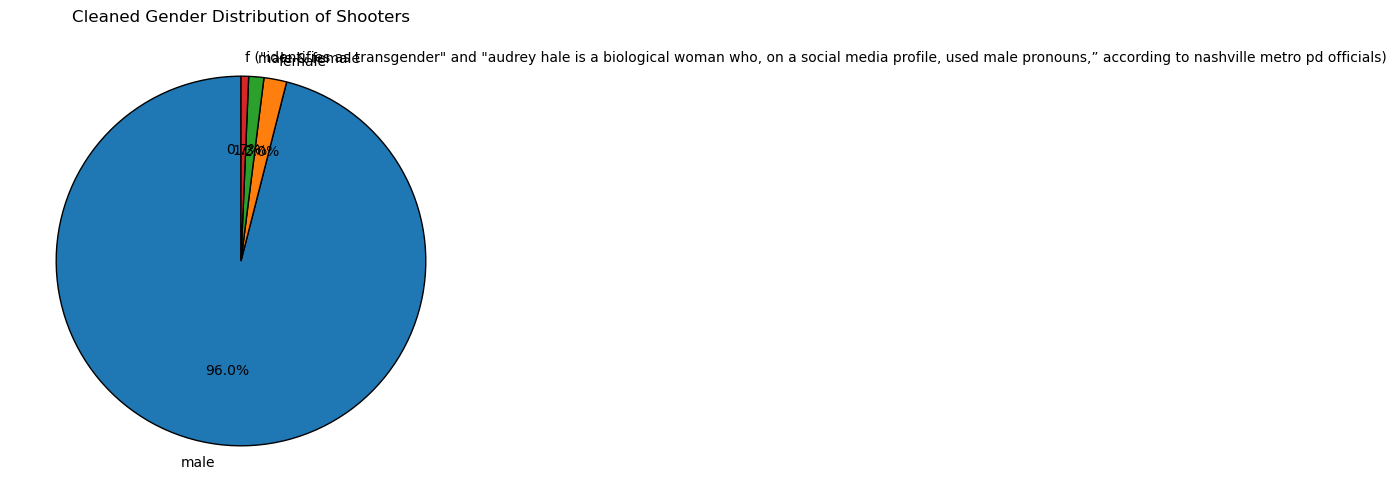

Heatmap saved to: C:\Users\venkateshgoud\Downloads\guru Project\US_Mass_Shootings_Heatmap.html
          Feature  Importance
1   total_victims    0.831005
3       longitude    0.090703
2        latitude    0.040574
0  age_of_shooter    0.037718


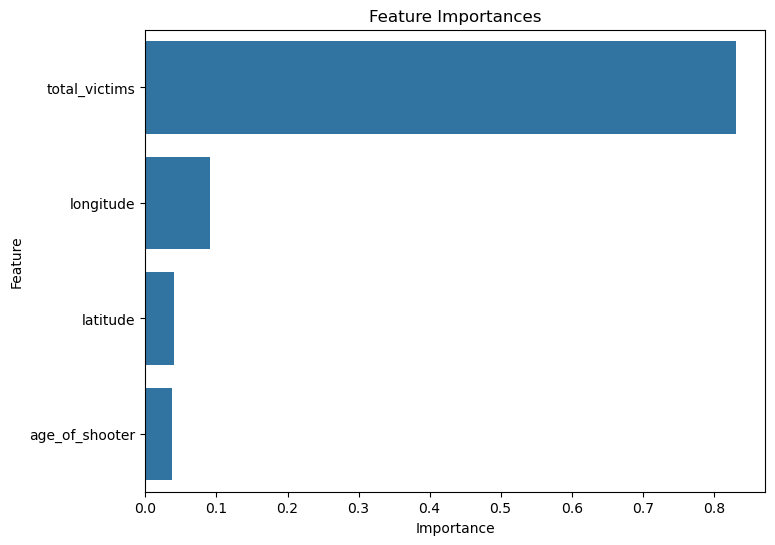

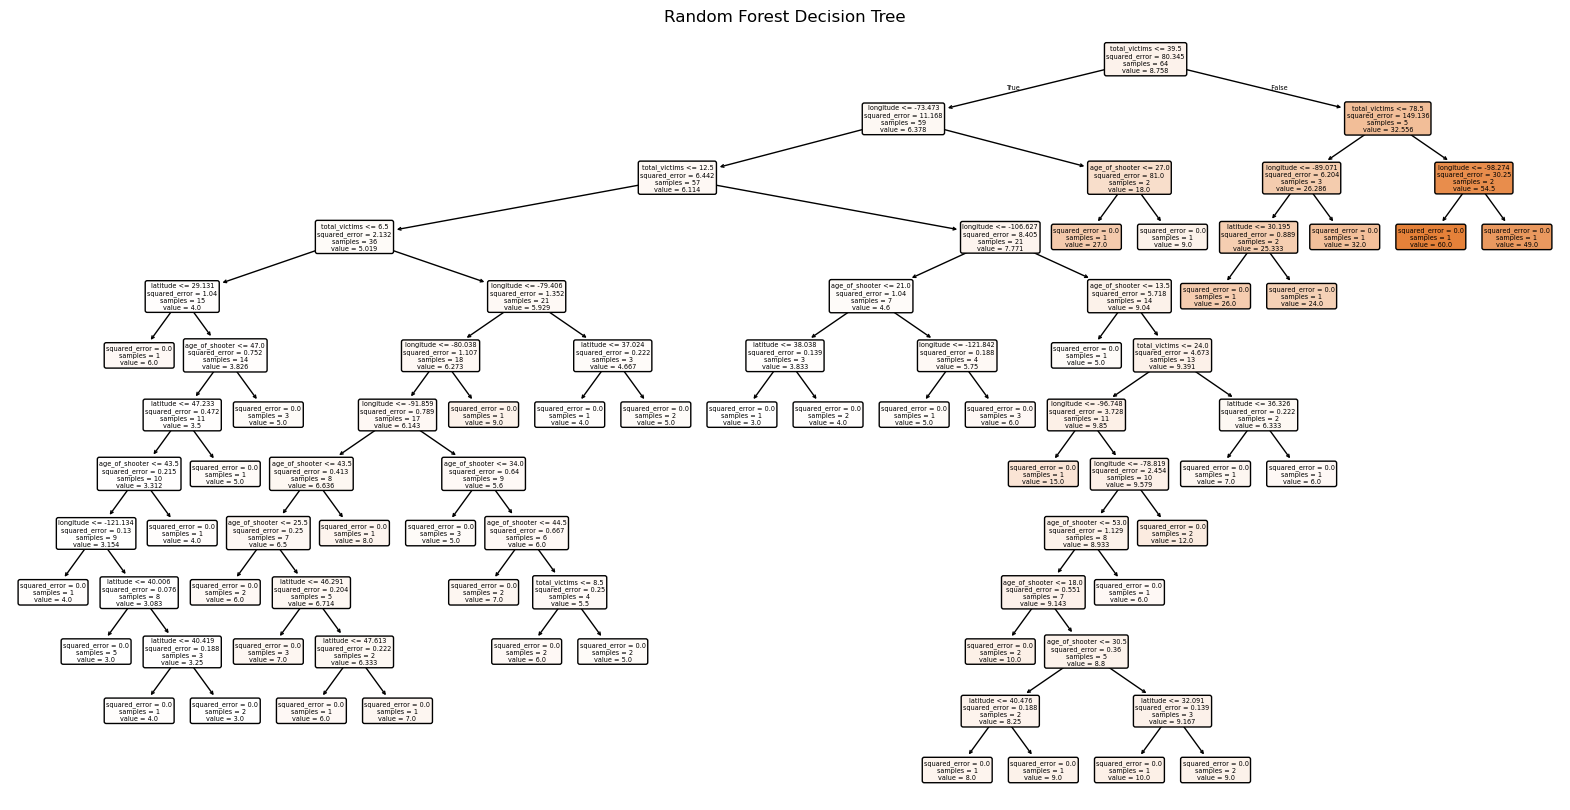

Missing values in regression variables: weapons_obtained_legally_encoded    123
age_of_shooter                        0
total_victims                         0
fatalities                            0
dtype: int64
Not enough data points for regression analysis. Remaining rows: 1


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import folium
from folium.plugins import HeatMap
import os

# Load the dataset
file_path = 'US_Mass_Shootings.csv'
mass_shootings_data = pd.read_csv(file_path)

# Display the first few rows and basic info
mass_shootings_data.head(), mass_shootings_data.info()

# Convert age_of_shooter to numeric, replacing non-numeric values with NaN
mass_shootings_data['age_of_shooter'] = pd.to_numeric(mass_shootings_data['age_of_shooter'], errors='coerce')

# Clean 'prior_signs_mental_health_issues' column
mass_shootings_data['prior_signs_mental_health_issues'] = mass_shootings_data['prior_signs_mental_health_issues'].str.lower()

# Replace '-' and empty strings with NaN
mass_shootings_data.replace(['-', ''], np.nan, inplace=True)

# Convert race and gender categories to consistent labels
mass_shootings_data['race'] = mass_shootings_data['race'].str.lower().str.strip()
mass_shootings_data['gender'] = mass_shootings_data['gender'].str.lower().str.strip()

# Collapse location types into fewer categories
location_mapping = {
    'workplace': 'workplace',
    'school': 'educational',
    'other': 'other',
    'residence': 'residential',
    'outdoor': 'public',
    'commercial': 'commercial'
}
mass_shootings_data['location.1'] = mass_shootings_data['location.1'].map(location_mapping)

# Convert date column to datetime
mass_shootings_data['date'] = pd.to_datetime(mass_shootings_data['date'], errors='coerce')

# Extract year and month
mass_shootings_data['year'] = mass_shootings_data['date'].dt.year
mass_shootings_data['month'] = mass_shootings_data['date'].dt.month

# Drop non-numeric columns for correlation analysis
numeric_data = mass_shootings_data.select_dtypes(include=[np.number])

# Analyze correlations
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Plot race distribution
plt.figure(figsize=(10, 6))
mass_shootings_data['race'].value_counts().plot(kind='bar')
plt.title("Cleaned Race Distribution of Shooters")
plt.xlabel("Race")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Correct gender categories for visualization
mass_shootings_data['gender'] = mass_shootings_data['gender'].replace({
    'm': 'male', 'f': 'female', 'transgender': 'other', 'other': 'other'
})

# Plot gender distribution
plt.figure(figsize=(6, 6))
mass_shootings_data['gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title("Cleaned Gender Distribution of Shooters")
plt.ylabel("")
plt.show()

# Create a heatmap with legend and explanation
mass_shootings_data['latitude'] = pd.to_numeric(mass_shootings_data['latitude'], errors='coerce')
mass_shootings_data['longitude'] = pd.to_numeric(mass_shootings_data['longitude'], errors='coerce')
geo_data = mass_shootings_data.dropna(subset=['latitude', 'longitude'])
map_shootings = folium.Map(location=[geo_data['latitude'].mean(), geo_data['longitude'].mean()], zoom_start=5)
heat_data = geo_data[['latitude', 'longitude']].dropna().values.tolist()
HeatMap(heat_data).add_to(map_shootings)
folium.LayerControl().add_to(map_shootings)
folium.Marker(location=[geo_data['latitude'].mean(), geo_data['longitude'].mean()], popup="Heatmap shows density of incidents").add_to(map_shootings)

# Save the map to the current working directory
output_file = os.path.join(os.getcwd(), "US_Mass_Shootings_Heatmap.html")
map_shootings.save(output_file)
print(f"Heatmap saved to: {output_file}")

# Feature importance with RF
features = ['age_of_shooter', 'total_victims', 'latitude', 'longitude']
mass_shootings_data = mass_shootings_data.dropna(subset=features + ['fatalities'])
X = mass_shootings_data[features]
y = mass_shootings_data['fatalities']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate RF
feature_importances = pd.DataFrame({'Feature': features, 'Importance': rf_model.feature_importances_}).sort_values(by='Importance', ascending=False)
print(feature_importances)
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title("Feature Importances")
plt.show()

# Visualize decision trees
from sklearn.tree import export_text, plot_tree
plt.figure(figsize=(20, 10))
plot_tree(rf_model.estimators_[0], feature_names=features, filled=True, rounded=True)
plt.title("Random Forest Decision Tree")
plt.show()

# Improved regression analysis with more variables
regression_vars = ['weapons_obtained_legally_encoded', 'age_of_shooter', 'total_victims']
mass_shootings_data['weapons_obtained_legally_encoded'] = mass_shootings_data['weapons_obtained_legally'].map({'yes': 1, 'no': 0})
missing_count = mass_shootings_data[regression_vars + ['fatalities']].isna().sum()
print("Missing values in regression variables:", missing_count)
mass_shootings_data = mass_shootings_data.dropna(subset=regression_vars + ['fatalities'])

if len(mass_shootings_data) > 1:
    X_policy = sm.add_constant(mass_shootings_data[regression_vars])
    y_policy = mass_shootings_data['fatalities']
    policy_model = sm.OLS(y_policy, X_policy).fit()
    print(policy_model.summary())
else:
    print(f"Not enough data points for regression analysis. Remaining rows: {len(mass_shootings_data)}")
